**# CELL 1: Setup & Imports**

In [1]:
import os
import shutil
import random
import json
from datetime import datetime
from collections import OrderedDict, Counter
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print("✅ Libraries imported")
print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")


✅ Libraries imported
PyTorch: 2.6.0+cu124, CUDA: True


**# CELL 2: Configuration & Helper Functions**

In [ ]:
# Paths (Kaggle-specific)
working_base = '/kaggle/working/MobilePlantViT'
data_dir = os.path.join(working_base, 'data')
master_directory_path = os.path.join(data_dir, 'PlantVillage_Master')
split_directory_path = os.path.join(data_dir, 'PlantVillage_Split')

# Directories
train_dir = os.path.join(split_directory_path, 'train')
val_dir = os.path.join(split_directory_path, 'val')
test_dir = os.path.join(split_directory_path, 'test')

# Split ratios
SPLIT_RATIO = {'train': 0.70, 'val': 0.15, 'test': 0.15}

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# DataLoader settings
BATCH_SIZE = 64
NUM_WORKERS = 4
PIN_MEMORY = True


def count_images_in_dir(directory):
    """Count total images and classes in a directory."""
    total_images = 0
    class_distribution = OrderedDict()
    
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_distribution[class_name] = len(images)
            total_images += len(images)
    
    return total_images, class_distribution

# Add to CELL 2 - after existing helper functions

def calculate_class_weights(class_distribution):
    """
    Calculate class weights for weighted loss.
    Uses inverse frequency weighting.
    """
    total_samples = sum(class_distribution.values())
    num_classes = len(class_distribution)
    
    class_weights = {}
    for class_name, count in class_distribution.items():
        # Inverse frequency weight
        weight = total_samples / (num_classes * count)
        class_weights[class_name] = weight
    
    return class_weights


def create_weighted_sampler(dataset, class_distribution):
    """
    Create WeightedRandomSampler for balanced batch sampling.
    """
    from torch.utils.data import WeightedRandomSampler
    
    # Calculate weights for each class
    class_weights = calculate_class_weights(class_distribution)
    
    # Assign weight to each sample based on its class
    sample_weights = []
    for img_path, class_idx in dataset.samples:
        class_name = dataset.classes[class_idx]
        sample_weights.append(class_weights[class_name])
    
    sample_weights = torch.DoubleTensor(sample_weights)
    
    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

print("✅ Balancing helper functions added")

def print_section(title):
    """Print formatted section header."""
    print("\n" + "=" * 80)
    print(f"  {title}")
    print("=" * 80)


print("✅ Configuration set")



✅ Configuration set


**# CELL 3: Dataset Discovery & Verification**

In [3]:
print_section("DATASET DISCOVERY")

# Find PlantVillage dataset in Kaggle input
possible_paths = [
    '/kaggle/input/plantvillage-dataset',
    '/kaggle/input/plant-village-dataset',
    '/kaggle/input/plantvillage'
]

dataset_input_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_input_path = path
        break

if not dataset_input_path:
    for item in os.listdir('/kaggle/input'):
        if 'plant' in item.lower():
            dataset_input_path = os.path.join('/kaggle/input', item)
            break

# Find class directory (the one containing actual class folders)
def find_class_directory(base_path):
    for root, dirs, files in os.walk(base_path):
        if dirs and any('___' in d or 'leaf' in d.lower() for d in dirs):
            for dir_name in dirs[:2]:
                test_path = os.path.join(root, dir_name)
                if os.path.isdir(test_path):
                    test_files = os.listdir(test_path)
                    if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in test_files):
                        return root
    return base_path

DATASET_PATH = find_class_directory(dataset_input_path)

# Count and display dataset info
total_images, class_distribution = count_images_in_dir(DATASET_PATH)
CLASS_NAMES = list(class_distribution.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"✅ Dataset found at: {DATASET_PATH}")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Total Images: {total_images:,}")
print(f"   Avg per Class: {total_images/NUM_CLASSES:.0f}")



  DATASET DISCOVERY
✅ Dataset found at: /kaggle/input/plantvillage-dataset/segmented
   Classes: 38
   Total Images: 54,306
   Avg per Class: 1429


**# CELL 4: Create Master Directory & Copy Images**

In [ ]:
print_section("DATASET QUALITY VERIFICATION")

def verify_image(image_path):
    """
    Verify if an image file is valid and not corrupted.
    Returns: (is_valid, error_message)
    """
    try:
        # Open and verify image
        with Image.open(image_path) as img:
            img.verify()  # Verify it's a valid image
        
        # Re-open for additional checks (verify() closes the file)
        with Image.open(image_path) as img:
            img.load()  # Actually load the image data
            
            # Check if image has valid dimensions
            if img.size[0] == 0 or img.size[1] == 0:
                return False, "Zero dimensions"
            
            # Check if image mode is valid
            if img.mode not in ['RGB', 'L', 'RGBA', 'P']:
                return False, f"Invalid mode: {img.mode}"
        
        return True, None
        
    except FileNotFoundError:
        return False, "File not found"
    except Image.UnidentifiedImageError:
        return False, "Unidentified image format"
    except OSError as e:
        return False, f"OS error: {str(e)}"
    except Exception as e:
        return False, f"Unexpected error: {str(e)}"


def scan_and_verify_dataset(dataset_path):
    """
    Scan entire dataset and verify all images.
    Returns: Dictionary with verification results
    """
    results = {
        'total_files': 0,
        'valid_images': 0,
        'corrupted_images': 0,
        'corrupted_files': [],
        'class_stats': {}
    }
    
    print("Scanning and verifying all images...")
    print("This may take a few minutes...\n")
    
    for class_name in tqdm(CLASS_NAMES, desc="Verifying classes"):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        # Initialize class stats
        results['class_stats'][class_name] = {
            'total': 0,
            'valid': 0,
            'corrupted': 0
        }
        
        # Get all image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            results['total_files'] += 1
            results['class_stats'][class_name]['total'] += 1
            
            # Verify image
            is_valid, error_msg = verify_image(img_path)
            
            if is_valid:
                results['valid_images'] += 1
                results['class_stats'][class_name]['valid'] += 1
            else:
                results['corrupted_images'] += 1
                results['class_stats'][class_name]['corrupted'] += 1
                results['corrupted_files'].append({
                    'path': img_path,
                    'class': class_name,
                    'filename': img_file,
                    'error': error_msg
                })
    
    return results


# Run verification
verification_results = scan_and_verify_dataset(DATASET_PATH)

# Display results
print("\n" + "=" * 80)
print("  VERIFICATION RESULTS")
print("=" * 80)

print(f"\n📊 Overall Statistics:")
print(f"   Total Files Scanned: {verification_results['total_files']:,}")
print(f"   ✅ Valid Images:     {verification_results['valid_images']:,} ({verification_results['valid_images']/verification_results['total_files']*100:.2f}%)")
print(f"   ❌ Corrupted Images: {verification_results['corrupted_images']:,} ({verification_results['corrupted_images']/verification_results['total_files']*100:.2f}%)")

# Show corrupted files if any
if verification_results['corrupted_images'] > 0:
    print(f"\n⚠️  WARNING: Found {verification_results['corrupted_images']} corrupted images!")
    print("\nCorrupted Files List:")
    print("-" * 80)
    
    for idx, corrupted in enumerate(verification_results['corrupted_files'][:10], 1):
        print(f"{idx}. Class: {corrupted['class']}")
        print(f"   File: {corrupted['filename']}")
        print(f"   Error: {corrupted['error']}")
        print(f"   Path: {corrupted['path']}")
        print()
    
    if len(verification_results['corrupted_files']) > 10:
        print(f"... and {len(verification_results['corrupted_files']) - 10} more corrupted files")
    
    # Save corrupted files list
    corrupted_log_path = os.path.join(working_base, 'corrupted_images_log.json')
    with open(corrupted_log_path, 'w') as f:
        json.dump(verification_results['corrupted_files'], f, indent=4)
    print(f"\n📝 Full corrupted files list saved to: {corrupted_log_path}")
    
    # Show classes with most corrupted images
    corrupted_by_class = [(cls, stats['corrupted']) 
                         for cls, stats in verification_results['class_stats'].items() 
                         if stats['corrupted'] > 0]
    
    if corrupted_by_class:
        corrupted_by_class.sort(key=lambda x: x[1], reverse=True)
        print(f"\n📉 Classes with Corrupted Images (Top 5):")
        for cls, count in corrupted_by_class[:5]:
            print(f"   {cls}: {count} corrupted")
    
    # Ask for action
    print("\n" + "=" * 80)
    print("⚠️  RECOMMENDED ACTIONS:")
    print("   1. Remove corrupted files before training")
    print("   2. Review the corrupted_images_log.json file")
    print("   3. Consider replacing corrupted images if possible")
    print("=" * 80)
    
else:
    print(f"\n✅ Great! No corrupted images found. Dataset is clean!")

# Summary by class
print(f"\n📋 Per-Class Statistics (showing first 10):")
print("-" * 80)
print(f"{'Class Name':<40} {'Total':<8} {'Valid':<8} {'Corrupted':<10}")
print("-" * 80)

for idx, (class_name, stats) in enumerate(list(verification_results['class_stats'].items())[:10]):
    print(f"{class_name:<40} {stats['total']:<8} {stats['valid']:<8} {stats['corrupted']:<10}")

if len(verification_results['class_stats']) > 10:
    print(f"... and {len(verification_results['class_stats']) - 10} more classes")

print("\n✅ Dataset quality verification complete!")

In [ ]:
print_section("DUPLICATE DETECTION & CLASS HARMONIZATION")

import hashlib
from collections import defaultdict

def compute_image_hash(image_path, hash_type='phash', hash_size=8):
    """
    Compute perceptual hash of an image.
    
    Args:
        image_path: Path to image file
        hash_type: 'phash' (perceptual) or 'ahash' (average)
        hash_size: Size of hash (default 8x8 = 64 bits)
    
    Returns:
        Hash string or None if error
    """
    try:
        with Image.open(image_path) as img:
            # Convert to grayscale
            img = img.convert('L')
            
            # Resize to hash_size x hash_size
            img = img.resize((hash_size, hash_size), Image.LANCZOS)
            
            # Convert to numpy array
            pixels = np.array(img).flatten()
            
            if hash_type == 'ahash':
                # Average Hash: compare each pixel to mean
                avg = pixels.mean()
                hash_bits = ''.join('1' if p > avg else '0' for p in pixels)
            
            elif hash_type == 'phash':
                # Perceptual Hash: use DCT (Discrete Cosine Transform)
                # Simplified version - resize and compare to median
                img_resized = img.resize((hash_size + 1, hash_size + 1), Image.LANCZOS)
                pixels_extended = np.array(img_resized).flatten()
                
                # Compute differences between adjacent pixels
                diff = []
                for i in range(len(pixels_extended) - 1):
                    diff.append(pixels_extended[i] < pixels_extended[i + 1])
                
                hash_bits = ''.join('1' if d else '0' for d in diff[:hash_size * hash_size])
            
            else:
                return None
            
            # Convert binary string to hex
            hash_hex = hex(int(hash_bits, 2))[2:].zfill(hash_size * hash_size // 4)
            return hash_hex
            
    except Exception as e:
        print(f"Error hashing {image_path}: {e}")
        return None


def hamming_distance(hash1, hash2):
    """Calculate Hamming distance between two hashes."""
    if hash1 is None or hash2 is None:
        return float('inf')
    
    # Convert hex to binary
    bin1 = bin(int(hash1, 16))[2:].zfill(len(hash1) * 4)
    bin2 = bin(int(hash2, 16))[2:].zfill(len(hash2) * 4)
    
    # Count differing bits
    return sum(b1 != b2 for b1, b2 in zip(bin1, bin2))


def find_duplicates(dataset_path, hash_type='phash', similarity_threshold=5):
    """
    Find duplicate images using perceptual hashing.
    
    Args:
        dataset_path: Path to dataset
        hash_type: 'phash' or 'ahash'
        similarity_threshold: Max Hamming distance to consider duplicates (0-64)
    
    Returns:
        Dictionary with duplicate information
    """
    print(f"Computing {hash_type.upper()} hashes for all images...")
    print(f"Similarity threshold: {similarity_threshold} bits\n")
    
    # Store: hash -> list of file paths
    hash_to_files = defaultdict(list)
    file_to_hash = {}
    
    total_files = 0
    
    # Compute hashes for all images
    for class_name in tqdm(CLASS_NAMES, desc="Hashing images"):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            
            # Compute hash
            img_hash = compute_image_hash(img_path, hash_type=hash_type)
            
            if img_hash:
                hash_to_files[img_hash].append(img_path)
                file_to_hash[img_path] = img_hash
                total_files += 1
    
    print(f"\n✅ Hashed {total_files:,} images")
    print(f"   Unique hashes: {len(hash_to_files):,}")
    
    # Find exact duplicates (same hash)
    exact_duplicates = {h: files for h, files in hash_to_files.items() if len(files) > 1}
    
    # Find near-duplicates (similar hashes)
    print(f"\nSearching for near-duplicates (Hamming distance ≤ {similarity_threshold})...")
    
    near_duplicate_groups = []
    processed_hashes = set()
    
    hash_list = list(hash_to_files.keys())
    
    for i, hash1 in enumerate(tqdm(hash_list, desc="Comparing hashes")):
        if hash1 in processed_hashes:
            continue
        
        duplicate_group = [hash1]
        
        # Compare with remaining hashes
        for hash2 in hash_list[i + 1:]:
            if hash2 in processed_hashes:
                continue
            
            distance = hamming_distance(hash1, hash2)
            
            if distance <= similarity_threshold:
                duplicate_group.append(hash2)
                processed_hashes.add(hash2)
        
        if len(duplicate_group) > 1:
            # Collect all files in this duplicate group
            files_in_group = []
            for h in duplicate_group:
                files_in_group.extend(hash_to_files[h])
            near_duplicate_groups.append(files_in_group)
        
        processed_hashes.add(hash1)
    
    # Compile results
    results = {
        'total_files': total_files,
        'unique_hashes': len(hash_to_files),
        'exact_duplicate_groups': exact_duplicates,
        'near_duplicate_groups': near_duplicate_groups,
        'file_to_hash': file_to_hash,
        'files_to_keep': set(),
        'files_to_remove': set()
    }
    
    # Determine which files to keep/remove
    all_duplicate_files = set()
    
    # From exact duplicates
    for files in exact_duplicates.values():
        # Keep first file, mark rest for removal
        results['files_to_keep'].add(files[0])
        for f in files[1:]:
            results['files_to_remove'].add(f)
            all_duplicate_files.add(f)
    
    # From near duplicates
    for files_group in near_duplicate_groups:
        # Keep first file, mark rest for removal
        results['files_to_keep'].add(files_group[0])
        for f in files_group[1:]:
            results['files_to_remove'].add(f)
            all_duplicate_files.add(f)
    
    results['total_duplicates'] = len(all_duplicate_files)
    
    return results


def harmonize_class_names(class_names):
    """
    Harmonize class names by fixing common issues.
    
    Returns:
        Dictionary mapping old names to new names
    """
    harmonization_map = {}
    
    for class_name in class_names:
        original = class_name
        harmonized = class_name
        
        # Fix common issues
        # 1. Replace multiple underscores with triple underscore
        while '____' in harmonized:
            harmonized = harmonized.replace('____', '___')
        
        # 2. Remove trailing/leading underscores
        harmonized = harmonized.strip('_')
        
        # 3. Standardize spacing around separator
        harmonized = harmonized.replace(' ___', '___').replace('___ ', '___')
        
        # 4. Fix capitalization inconsistencies
        parts = harmonized.split('___')
        if len(parts) == 2:
            plant, condition = parts
            # Capitalize plant name properly
            plant = plant.replace('_', ' ').title().replace(' ', '_')
            # Capitalize condition
            condition = condition.replace('_', ' ').title().replace(' ', '_')
            harmonized = f"{plant}___{condition}"
        
        if original != harmonized:
            harmonization_map[original] = harmonized
    
    return harmonization_map


# Run duplicate detection
duplicate_results = find_duplicates(
    DATASET_PATH, 
    hash_type='phash',  # Use perceptual hash
    similarity_threshold=5  # Allow up to 5 bits difference
)

# Display results
print("\n" + "=" * 80)
print("  DUPLICATE DETECTION RESULTS")
print("=" * 80)

print(f"\n📊 Overall Statistics:")
print(f"   Total Files Scanned:    {duplicate_results['total_files']:,}")
print(f"   Unique Image Hashes:    {duplicate_results['unique_hashes']:,}")
print(f"   Exact Duplicates Found: {len(duplicate_results['exact_duplicate_groups']):,} groups")
print(f"   Near Duplicates Found:  {len(duplicate_results['near_duplicate_groups']):,} groups")
print(f"   Total Duplicate Files:  {duplicate_results['total_duplicates']:,}")
print(f"   Files to Remove:        {len(duplicate_results['files_to_remove']):,}")
print(f"   Unique Images:          {duplicate_results['total_files'] - duplicate_results['total_duplicates']:,}")

# Show exact duplicate examples
if duplicate_results['exact_duplicate_groups']:
    print(f"\n🔍 Exact Duplicate Examples (first 5 groups):")
    print("-" * 80)
    
    for idx, (hash_val, files) in enumerate(list(duplicate_results['exact_duplicate_groups'].items())[:5], 1):
        print(f"\nGroup {idx} (Hash: {hash_val[:16]}...)")
        print(f"   Duplicate count: {len(files)}")
        for f in files[:3]:
            class_name = os.path.basename(os.path.dirname(f))
            filename = os.path.basename(f)
            print(f"   • {class_name}/{filename}")
        if len(files) > 3:
            print(f"   ... and {len(files) - 3} more duplicates")

# Show near duplicate examples
if duplicate_results['near_duplicate_groups']:
    print(f"\n🔍 Near Duplicate Examples (first 5 groups):")
    print("-" * 80)
    
    for idx, files in enumerate(duplicate_results['near_duplicate_groups'][:5], 1):
        print(f"\nGroup {idx}")
        print(f"   Similar images: {len(files)}")
        for f in files[:3]:
            class_name = os.path.basename(os.path.dirname(f))
            filename = os.path.basename(f)
            print(f"   • {class_name}/{filename}")
        if len(files) > 3:
            print(f"   ... and {len(files) - 3} more similar images")

# Save duplicate report
if duplicate_results['total_duplicates'] > 0:
    duplicate_report = {
        'summary': {
            'total_files': duplicate_results['total_files'],
            'total_duplicates': duplicate_results['total_duplicates'],
            'files_to_remove': len(duplicate_results['files_to_remove'])
        },
        'files_to_remove': list(duplicate_results['files_to_remove'])
    }
    
    duplicate_log_path = os.path.join(working_base, 'duplicate_files_log.json')
    with open(duplicate_log_path, 'w') as f:
        json.dump(duplicate_report, f, indent=4)
    print(f"\n📝 Duplicate files list saved to: {duplicate_log_path}")

# Class name harmonization
print("\n" + "=" * 80)
print("  CLASS NAME HARMONIZATION")
print("=" * 80)

harmonization_map = harmonize_class_names(CLASS_NAMES)

if harmonization_map:
    print(f"\n⚠️  Found {len(harmonization_map)} class names to harmonize:")
    print("-" * 80)
    
    for old_name, new_name in list(harmonization_map.items())[:10]:
        print(f"   {old_name}")
        print(f"   → {new_name}\n")
    
    if len(harmonization_map) > 10:
        print(f"... and {len(harmonization_map) - 10} more renames")
    
    harmonization_log_path = os.path.join(working_base, 'class_harmonization_log.json')
    with open(harmonization_log_path, 'w') as f:
        json.dump(harmonization_map, f, indent=4)
    print(f"\n📝 Class harmonization map saved to: {harmonization_log_path}")
else:
    print(f"\n✅ All class names are already harmonized!")

# Summary
print("\n" + "=" * 80)
print("  RECOMMENDED ACTIONS")
print("=" * 80)

if duplicate_results['total_duplicates'] > 0:
    print(f"\n⚠️  Duplicates Detected:")
    print(f"   • {duplicate_results['total_duplicates']:,} duplicate files found")
    print(f"   • Duplicates will be automatically excluded during copy")
    print(f"   • This will save storage and prevent data leakage")
    
if harmonization_map:
    print(f"\n⚠️  Class Names:")
    print(f"   • {len(harmonization_map)} classes need renaming")
    print(f"   • New names will be applied during directory creation")

print("\n✅ Duplicate detection and harmonization complete!")

In [ ]:
print_section("MASTER DIRECTORY CREATION (WITH FILTERING)")

os.makedirs(master_directory_path, exist_ok=True)

# Combine corrupted and duplicate files to skip
files_to_skip = set(item['path'] for item in verification_results['corrupted_files'])
files_to_skip.update(duplicate_results['files_to_remove'])

print("Copying valid, unique images to master directory...")
print(f"Skipping {len(verification_results['corrupted_files'])} corrupted files")
print(f"Skipping {len(duplicate_results['files_to_remove'])} duplicate files")
print(f"Total files to skip: {len(files_to_skip)}\n")

total_copied = 0
total_skipped_corrupted = 0
total_skipped_duplicate = 0

# Create reverse harmonization lookup for faster access
harmonized_classes = {}
for old_name in CLASS_NAMES:
    new_name = harmonization_map.get(old_name, old_name)
    harmonized_classes[old_name] = new_name

for class_name in tqdm(CLASS_NAMES, desc="Copying classes"):
    src_path = os.path.join(DATASET_PATH, class_name)
    
    # Use harmonized class name for destination
    harmonized_name = harmonized_classes[class_name]
    dst_path = os.path.join(master_directory_path, harmonized_name)
    os.makedirs(dst_path, exist_ok=True)
    
    images = [f for f in os.listdir(src_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    for img in images:
        src_file = os.path.join(src_path, img)
        dst_file = os.path.join(dst_path, img)
        
        # Skip corrupted or duplicate images
        if src_file in files_to_skip:
            if src_file in set(item['path'] for item in verification_results['corrupted_files']):
                total_skipped_corrupted += 1
            else:
                total_skipped_duplicate += 1
            continue
        
        if not os.path.exists(dst_file):
            try:
                shutil.copy2(src_file, dst_file)
                total_copied += 1
            except Exception as e:
                print(f"\n⚠️  Failed to copy {img}: {e}")

# Verify
master_total, master_dist = count_images_in_dir(master_directory_path)

# Update CLASS_NAMES to harmonized names
CLASS_NAMES = sorted(list(set(harmonized_classes.values())))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n✅ Master directory created")
print(f"   Copied:             {total_copied:,} valid, unique images")
print(f"   Skipped (corrupted): {total_skipped_corrupted:,} files")
print(f"   Skipped (duplicate): {total_skipped_duplicate:,} files")
print(f"   Verified:           {master_total:,} images in master directory")
print(f"   Classes:            {NUM_CLASSES} (after harmonization)")

# Verification
expected_skipped = len(files_to_skip)
actual_skipped = total_skipped_corrupted + total_skipped_duplicate

if actual_skipped == expected_skipped:
    print(f"   ✅ All problematic files successfully filtered!")
else:
    print(f"   ⚠️  Expected to skip {expected_skipped}, actually skipped {actual_skipped}")

# Show harmonization results if any
if harmonization_map:
    print(f"\n✅ Class names harmonized: {len(harmonization_map)} classes renamed")

In [ ]:
# New Cell: Class Imbalance Analysis

print_section("CLASS IMBALANCE ANALYSIS")

# Count images per class in master directory
_, master_class_distribution = count_images_in_dir(master_directory_path)

# Calculate statistics
class_counts = list(master_class_distribution.values())
total_images = sum(class_counts)
mean_count = np.mean(class_counts)
median_count = np.median(class_counts)
std_count = np.std(class_counts)
min_count = min(class_counts)
max_count = max(class_counts)

# Calculate imbalance ratio
imbalance_ratio = max_count / min_count

print(f"📊 Class Distribution Statistics:")
print(f"   Total Classes:     {len(master_class_distribution)}")
print(f"   Total Images:      {total_images:,}")
print(f"   Mean per Class:    {mean_count:.1f}")
print(f"   Median per Class:  {median_count:.1f}")
print(f"   Std Dev:           {std_count:.1f}")
print(f"   Min Count:         {min_count}")
print(f"   Max Count:         {max_count}")
print(f"   Imbalance Ratio:   {imbalance_ratio:.2f}x")

# Classify imbalance severity
if imbalance_ratio <= 1.5:
    severity = "✅ BALANCED"
    recommendation = "No balancing needed"
elif imbalance_ratio <= 3:
    severity = "⚠️  SLIGHT IMBALANCE"
    recommendation = "Consider weighted loss or class weights"
elif imbalance_ratio <= 10:
    severity = "🔶 MODERATE IMBALANCE"
    recommendation = "Use weighted sampling or oversampling"
else:
    severity = "❌ SEVERE IMBALANCE"
    recommendation = "Use SMOTE, oversampling, or combined strategies"

print(f"\n{severity}")
print(f"   Recommendation: {recommendation}")

# Show top 10 largest and smallest classes
sorted_classes = sorted(master_class_distribution.items(), key=lambda x: x[1], reverse=True)

print(f"\n📈 Largest Classes (Top 10):")
print("-" * 80)
print(f"{'Class Name':<50} {'Count':<10} {'% of Total':<12}")
print("-" * 80)
for class_name, count in sorted_classes[:10]:
    percentage = (count / total_images) * 100
    print(f"{class_name:<50} {count:<10} {percentage:>6.2f}%")

print(f"\n📉 Smallest Classes (Bottom 10):")
print("-" * 80)
print(f"{'Class Name':<50} {'Count':<10} {'% of Total':<12}")
print("-" * 80)
for class_name, count in sorted_classes[-10:]:
    percentage = (count / total_images) * 100
    print(f"{class_name:<50} {count:<10} {percentage:>6.2f}%")

# Visualize distribution
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of class sizes
plt.subplot(1, 2, 1)
plt.hist(class_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.0f}')
plt.axvline(median_count, color='green', linestyle='--', label=f'Median: {median_count:.0f}')
plt.xlabel('Number of Images per Class')
plt.ylabel('Frequency')
plt.title('Distribution of Images Across Classes')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Sorted class sizes
plt.subplot(1, 2, 2)
sorted_counts = sorted(class_counts, reverse=True)
plt.plot(sorted_counts, color='coral', linewidth=2)
plt.xlabel('Class Rank')
plt.ylabel('Number of Images')
plt.title('Class Sizes (Sorted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save imbalance report
imbalance_report = {
    'total_classes': len(master_class_distribution),
    'total_images': total_images,
    'statistics': {
        'mean': float(mean_count),
        'median': float(median_count),
        'std': float(std_count),
        'min': int(min_count),
        'max': int(max_count),
        'imbalance_ratio': float(imbalance_ratio)
    },
    'severity': severity,
    'recommendation': recommendation,
    'class_distribution': master_class_distribution
}

imbalance_log_path = os.path.join(working_base, 'class_imbalance_analysis.json')
with open(imbalance_log_path, 'w') as f:
    json.dump(imbalance_report, f, indent=4)

print(f"\n📝 Imbalance analysis saved to: {imbalance_log_path}")
print("✅ Class imbalance analysis complete!")

**# CELL 5: Create Split Directories**

In [5]:
print_section("SPLIT DIRECTORY CREATION")

# Create main split directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Create class folders in each split
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

print(f"✅ Split directories created")
print(f"   Train: {train_dir}")
print(f"   Val:   {val_dir}")
print(f"   Test:  {test_dir}")



  SPLIT DIRECTORY CREATION
✅ Split directories created
   Train: /kaggle/working/MobilePlantViT/data/PlantVillage_Split/train
   Val:   /kaggle/working/MobilePlantViT/data/PlantVillage_Split/val
   Test:  /kaggle/working/MobilePlantViT/data/PlantVillage_Split/test


**# CELL 6: Split Dataset into Train/Val/Test**

In [ ]:
# CELL 6 (ENHANCED): Split Dataset with Balancing Options

print_section("SPLITTING DATASET WITH BALANCING (70/15/15)")

# ============================================================================
# CONFIGURATION: Choose your balancing strategy
# ============================================================================
BALANCING_STRATEGY = 'weighted_sampling'  # Options: 'none', 'weighted_sampling', 'oversample_minority', 'undersample_majority'

# Threshold for considering a class as minority (e.g., < 80% of median)
MINORITY_THRESHOLD = 0.8

# ============================================================================

split_stats = {
    'total_images': 0,
    'train_images': 0,
    'val_images': 0,
    'test_images': 0,
    'class_distribution': {},
    'minority_classes': [],
    'majority_classes': []
}

# Identify minority and majority classes
_, master_dist = count_images_in_dir(master_directory_path)
median_count = np.median(list(master_dist.values()))
minority_threshold_count = median_count * MINORITY_THRESHOLD

for class_name in CLASS_NAMES:
    count = master_dist[class_name]
    split_stats['class_distribution'][class_name] = {
        'total': count,
        'train': 0,
        'val': 0,
        'test': 0
    }
    
    if count < minority_threshold_count:
        split_stats['minority_classes'].append(class_name)
    else:
        split_stats['majority_classes'].append(class_name)

print(f"📊 Class Analysis:")
print(f"   Minority Classes ({len(split_stats['minority_classes'])}): < {minority_threshold_count:.0f} images")
print(f"   Majority Classes ({len(split_stats['majority_classes'])}): >= {minority_threshold_count:.0f} images")
print(f"   Strategy: {BALANCING_STRATEGY}")

# Perform splitting
if BALANCING_STRATEGY == 'oversample_minority':
    # Strategy 1: Oversample minority classes to match median
    print("\n🔄 Applying oversampling to minority classes...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting with oversampling"):
        class_source_path = os.path.join(master_directory_path, class_name)
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Determine if oversampling is needed
        is_minority = class_name in split_stats['minority_classes']
        
        if is_minority:
            # Oversample to median count
            target_count = int(median_count)
            if len(images) < target_count:
                # Replicate images to reach target
                multiplier = int(np.ceil(target_count / len(images)))
                images = images * multiplier
                images = images[:target_count]
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            src = os.path.join(class_source_path, img)
            dst = os.path.join(train_dir, class_name, img)
            
            # Handle duplicates from oversampling
            if os.path.exists(dst):
                base, ext = os.path.splitext(img)
                counter = 1
                while os.path.exists(dst):
                    new_name = f"{base}_dup{counter}{ext}"
                    dst = os.path.join(train_dir, class_name, new_name)
                    counter += 1
            
            shutil.copy2(src, dst)
        
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

elif BALANCING_STRATEGY == 'undersample_majority':
    # Strategy 2: Undersample majority classes to match median
    print("\n🔄 Applying undersampling to majority classes...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting with undersampling"):
        class_source_path = os.path.join(master_directory_path, class_name)
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Determine if undersampling is needed
        is_majority = class_name in split_stats['majority_classes']
        
        if is_majority:
            # Undersample to median count
            target_count = int(median_count)
            if len(images) > target_count:
                # Randomly sample target_count images
                random.shuffle(images)
                images = images[:target_count]
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

else:
    # Strategy 3: Standard split (no balancing) or weighted_sampling (handled in dataloader)
    print("\n🔄 Performing standard split...")
    
    for class_name in tqdm(CLASS_NAMES, desc="Splitting"):
        class_source_path = os.path.join(master_directory_path, class_name)
        
        # Get all images
        images = sorted([f for f in os.listdir(class_source_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate split indices
        total = len(images)
        train_count = int(total * SPLIT_RATIO['train'])
        val_count = int(total * SPLIT_RATIO['val'])
        
        # Split
        train_imgs = images[:train_count]
        val_imgs = images[train_count:train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        # Copy to respective directories
        for img in train_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(val_dir, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_source_path, img),
                        os.path.join(test_dir, class_name, img))
        
        # Update stats
        split_stats['total_images'] += total
        split_stats['train_images'] += len(train_imgs)
        split_stats['val_images'] += len(val_imgs)
        split_stats['test_images'] += len(test_imgs)
        
        split_stats['class_distribution'][class_name]['train'] = len(train_imgs)
        split_stats['class_distribution'][class_name]['val'] = len(val_imgs)
        split_stats['class_distribution'][class_name]['test'] = len(test_imgs)

print(f"\n✅ Dataset split complete")
print(f"   Total:  {split_stats['total_images']:,}")
print(f"   Train:  {split_stats['train_images']:,} ({split_stats['train_images']/split_stats['total_images']*100:.1f}%)")
print(f"   Val:    {split_stats['val_images']:,} ({split_stats['val_images']/split_stats['total_images']*100:.1f}%)")
print(f"   Test:   {split_stats['test_images']:,} ({split_stats['test_images']/split_stats['total_images']*100:.1f}%)")

# Analyze balance after splitting
train_counts = [stats['train'] for stats in split_stats['class_distribution'].values()]
new_imbalance_ratio = max(train_counts) / min(train_counts)

print(f"\n📊 Training Set Balance:")
print(f"   Before Strategy: {imbalance_ratio:.2f}x")
print(f"   After Strategy:  {new_imbalance_ratio:.2f}x")
if new_imbalance_ratio < imbalance_ratio:
    improvement = ((imbalance_ratio - new_imbalance_ratio) / imbalance_ratio) * 100
    print(f"   ✅ Improvement: {improvement:.1f}%")


  SPLITTING DATASET (70/15/15)


Splitting:   0%|          | 0/38 [00:00<?, ?it/s]

✅ Dataset split complete
   Total:  54,306
   Train:  37,997 (70.0%)
   Val:    8,129 (15.0%)
   Test:   8,180 (15.1%)


**# CELL 7: Define Transformations**

In [7]:
print_section("PREPROCESSING PIPELINE")

# Training transform (WITH augmentations)
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), 
                           scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                          saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Val/Test transform (NO augmentations)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print(f"✅ Transforms defined")
print(f"   Train:    {len(transform_train.transforms)} steps (WITH augmentations)")
print(f"   Val/Test: {len(transform_val_test.transforms)} steps (NO augmentations)")



  PREPROCESSING PIPELINE
✅ Transforms defined
   Train:    9 steps (WITH augmentations)
   Val/Test: 3 steps (NO augmentations)


**# CELL 8: Create Datasets**

In [8]:
print_section("DATASET CREATION")

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_val_test)

print(f"✅ Datasets created")
print(f"   Train: {len(train_dataset):,} images")
print(f"   Val:   {len(val_dataset):,} images")
print(f"   Test:  {len(test_dataset):,} images")
print(f"   Classes: {len(train_dataset.classes)}")



  DATASET CREATION
✅ Datasets created
   Train: 37,997 images
   Val:   8,129 images
   Test:  8,180 images
   Classes: 38


**# CELL 9: Create DataLoaders**

In [ ]:
# CELL 9 (ENHANCED): Create DataLoaders with Balancing

print_section("DATALOADER CREATION WITH BALANCING")

# Determine if we need weighted sampling
use_weighted_sampling = (BALANCING_STRATEGY == 'weighted_sampling' and 
                         imbalance_ratio > 2.0)

if use_weighted_sampling:
    print("🔄 Creating weighted sampler for balanced batches...")
    
    # Get train set class distribution
    train_class_dist = count_images_in_dir(train_dir)[1]
    
    # Create weighted sampler
    train_sampler = create_weighted_sampler(train_dataset, train_class_dist)
    
    # Create train loader with sampler (no shuffle when using sampler)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,  # Use sampler instead of shuffle
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    print(f"✅ Weighted sampling enabled")
    print(f"   This will create balanced batches during training")

else:
    # Standard dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        prefetch_factor=2,
        persistent_workers=True
    )

# Val and test loaders remain unchanged
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=2,
    persistent_workers=True
)

print(f"\n✅ DataLoaders created")
print(f"   Train: {len(train_loader)} batches (balanced={use_weighted_sampling})")
print(f"   Val:   {len(val_loader)} batches (shuffle=False)")
print(f"   Test:  {len(test_loader)} batches (shuffle=False)")


  DATALOADER CREATION
✅ DataLoaders created
   Train: 594 batches (shuffle=True)
   Val:   128 batches (shuffle=False)
   Test:  128 batches (shuffle=False)


**# CELL 10: Visualization - Sample Images**


  SAMPLE VISUALIZATION


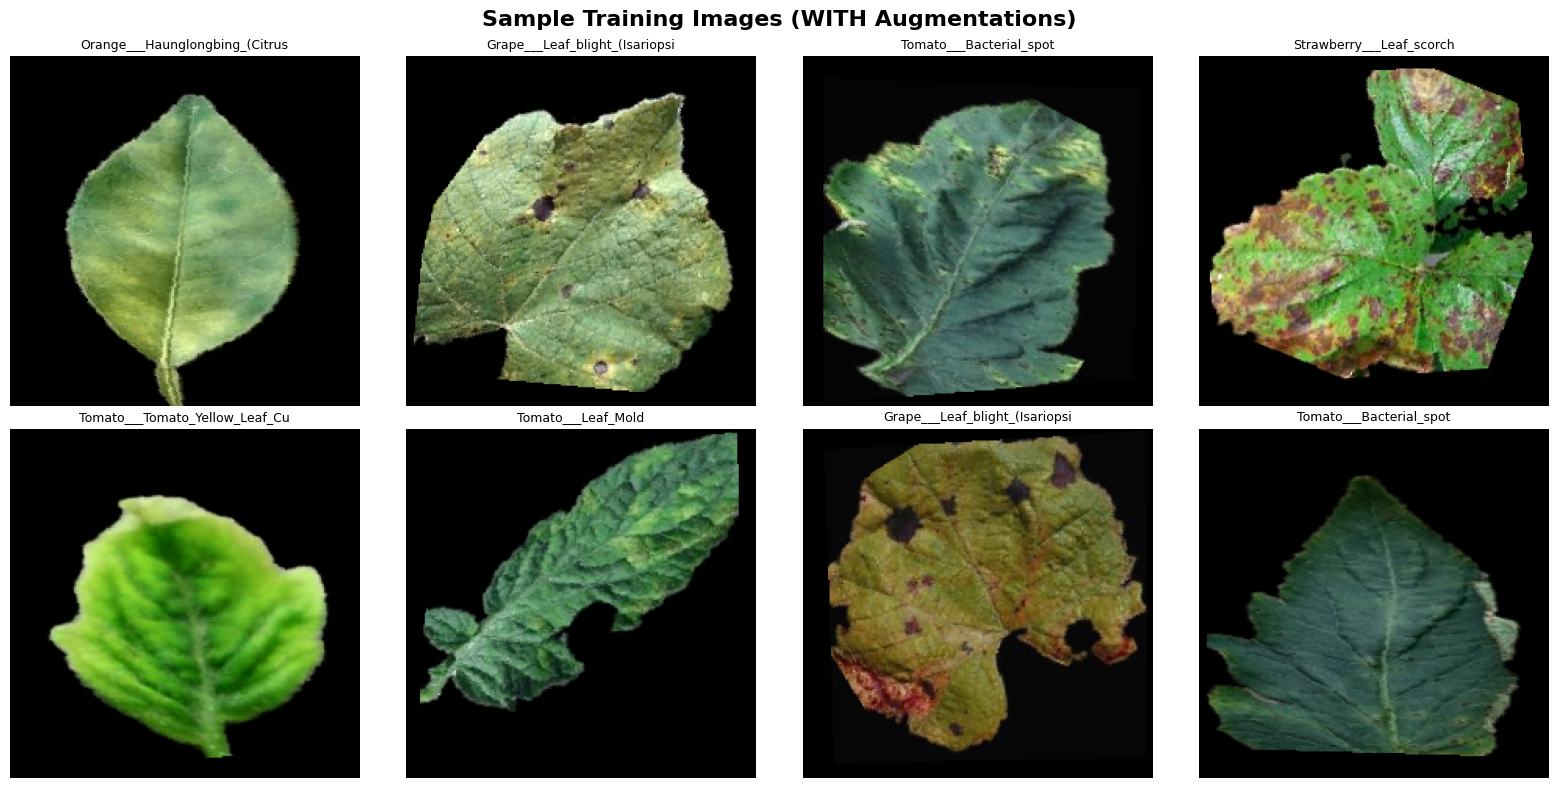

✅ Sample images displayed


In [10]:
print_section("SAMPLE VISUALIZATION")

def denormalize(tensor):
    """Denormalize tensor for visualization."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Get sample batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Training Images (WITH Augmentations)', 
             fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx])
    img = img.permute(1, 2, 0).numpy()
    
    ax.imshow(img)
    class_name = train_dataset.classes[labels[idx]]
    ax.set_title(class_name[:30], fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample images displayed")


**# CELL 11: Model Setup (Verification)**

In [11]:
print_section("MODEL SETUP")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)

# Model stats
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model loaded: MobileNetV2")
print(f"   Device: {device}")
print(f"   Parameters: {total_params:,}")
print(f"   Output Classes: {NUM_CLASSES}")



  MODEL SETUP


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 162MB/s]

✅ Model loaded: MobileNetV2
   Device: cuda
   Parameters: 2,272,550
   Output Classes: 38


**# CELL 12: Pipeline Verification**

In [12]:
print_section("PIPELINE VERIFICATION")

model.eval()

# Test forward pass
images_batch, labels_batch = next(iter(train_loader))
images_batch = images_batch.to(device)
labels_batch = labels_batch.to(device)

with torch.no_grad():
    start = time.time()
    outputs = model(images_batch)
    forward_time = time.time() - start
    
    _, predictions = torch.max(outputs, 1)

print(f"✅ Forward pass successful")
print(f"   Input shape:  {tuple(images_batch.shape)}")
print(f"   Output shape: {tuple(outputs.shape)}")
print(f"   Time: {forward_time*1000:.2f} ms")
print(f"   Throughput: {len(images_batch)/forward_time:.1f} images/sec")



  PIPELINE VERIFICATION
✅ Forward pass successful
   Input shape:  (64, 3, 224, 224)
   Output shape: (64, 38)
   Time: 947.06 ms
   Throughput: 67.6 images/sec


**# CELL 13: Complete Pipeline Summary**

In [13]:
print("\n" + "=" * 80)
print("  COMPLETE PIPELINE SUMMARY")
print("=" * 80)

summary = f"""
📊 Dataset Configuration:
   • Source: PlantVillage (Kaggle)
   • Classes: {NUM_CLASSES}
   • Total Images: {split_stats['total_images']:,}
   • Train: {split_stats['train_images']:,} ({split_stats['train_images']/split_stats['total_images']*100:.1f}%)
   • Val:   {split_stats['val_images']:,} ({split_stats['val_images']/split_stats['total_images']*100:.1f}%)
   • Test:  {split_stats['test_images']:,} ({split_stats['test_images']/split_stats['total_images']*100:.1f}%)

🔄 Data Pipeline:
   • Batch Size: {BATCH_SIZE}
   • Workers: {NUM_WORKERS}
   • Train Batches: {len(train_loader):,}
   • Val Batches: {len(val_loader):,}
   • Test Batches: {len(test_loader):,}

🎨 Transformations:
   • Training: 9 steps WITH augmentations
   • Val/Test: 3 steps NO augmentations
   • Normalization: ImageNet statistics

🤖 Model:
   • Architecture: MobileNetV2
   • Parameters: {total_params:,}
   • Device: {device}
   • Output: {NUM_CLASSES} classes

✅ Pipeline Status: READY FOR TRAINING
"""

print(summary)
print("=" * 80)



  COMPLETE PIPELINE SUMMARY

📊 Dataset Configuration:
   • Source: PlantVillage (Kaggle)
   • Classes: 38
   • Total Images: 54,306
   • Train: 37,997 (70.0%)
   • Val:   8,129 (15.0%)
   • Test:  8,180 (15.1%)

🔄 Data Pipeline:
   • Batch Size: 64
   • Workers: 4
   • Train Batches: 594
   • Val Batches: 128
   • Test Batches: 128

🎨 Transformations:
   • Training: 9 steps WITH augmentations
   • Val/Test: 3 steps NO augmentations
   • Normalization: ImageNet statistics

🤖 Model:
   • Architecture: MobileNetV2
   • Parameters: 2,272,550
   • Device: cuda
   • Output: 38 classes

✅ Pipeline Status: READY FOR TRAINING



**# CELL 14: Training Loop**

In [ ]:
# In CELL 14 - REPLACE the criterion line with:

print_section("TRAINING LOOP WITH CLASS BALANCING")

# Calculate class weights for loss function
use_weighted_loss = (BALANCING_STRATEGY in ['none', 'weighted_sampling'] and 
                     imbalance_ratio > 2.0)

if use_weighted_loss:
    print("🔄 Calculating class weights for weighted loss...")
    
    # Get class distribution from training set
    train_class_dist = count_images_in_dir(train_dir)[1]
    class_weights_dict = calculate_class_weights(train_class_dist)
    
    # Convert to tensor (must match class order in dataset)
    class_weights_list = [class_weights_dict[cls] for cls in train_dataset.classes]
    class_weights_tensor = torch.FloatTensor(class_weights_list).to(device)
    
    # Create weighted loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    print(f"✅ Weighted loss enabled")
    print(f"   Weight range: {min(class_weights_list):.3f} - {max(class_weights_list):.3f}")
else:
    # Standard loss
    criterion = nn.CrossEntropyLoss()
    print(f"✅ Standard loss (no class weights)")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=3)

NUM_EPOCHS = 10  # Adjust as needed
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
    
    # Calculate training metrics
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    
    # Calculate validation metrics
    val_loss = val_loss / len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ Model saved (val_acc: {val_acc:.4f})")

print(f"\n🎉 Training complete! Best Val Acc: {best_val_acc:.4f}")


  TRAINING LOOP

Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.4278 | Train Acc: 0.8678
Val Loss:   0.1874 | Val Acc:   0.9392
✅ Model saved (val_acc: 0.9392)

Epoch 2/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.2208 | Train Acc: 0.9279
Val Loss:   0.1740 | Val Acc:   0.9426
✅ Model saved (val_acc: 0.9426)

Epoch 3/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1699 | Train Acc: 0.9447
Val Loss:   0.1596 | Val Acc:   0.9504
✅ Model saved (val_acc: 0.9504)

Epoch 4/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1643 | Train Acc: 0.9453
Val Loss:   0.1334 | Val Acc:   0.9590
✅ Model saved (val_acc: 0.9590)

Epoch 5/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1454 | Train Acc: 0.9518
Val Loss:   0.1108 | Val Acc:   0.9659
✅ Model saved (val_acc: 0.9659)

Epoch 6/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1249 | Train Acc: 0.9591
Val Loss:   0.1205 | Val Acc:   0.9593

Epoch 7/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1223 | Train Acc: 0.9587
Val Loss:   0.0926 | Val Acc:   0.9707
✅ Model saved (val_acc: 0.9707)

Epoch 8/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1165 | Train Acc: 0.9621
Val Loss:   0.0746 | Val Acc:   0.9760
✅ Model saved (val_acc: 0.9760)

Epoch 9/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1023 | Train Acc: 0.9667
Val Loss:   0.1066 | Val Acc:   0.9676

Epoch 10/10
------------------------------------------------------------


Training:   0%|          | 0/594 [00:00<?, ?it/s]

Validation:   0%|          | 0/128 [00:00<?, ?it/s]

Train Loss: 0.1084 | Train Acc: 0.9647
Val Loss:   0.0697 | Val Acc:   0.9790
✅ Model saved (val_acc: 0.9790)

🎉 Training complete! Best Val Acc: 0.9790


**# CELL 15: Evaluate on Test Set**

In [15]:
print_section("TEST SET EVALUATION")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        
        # Store for confusion matrix later
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_dataset)
test_acc = test_correct / len(test_dataset)

print(f"✅ Test Set Results:")
print(f"   Test Loss:     {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc*100:.2f}%")
print(f"   Total Images:  {len(test_dataset):,}")
print(f"   Correct:       {test_correct:,}")
print(f"   Incorrect:     {len(test_dataset) - test_correct:,}")


  TEST SET EVALUATION


Testing:   0%|          | 0/128 [00:00<?, ?it/s]

✅ Test Set Results:
   Test Loss:     0.0590
   Test Accuracy: 97.98%
   Total Images:  8,180
   Correct:       8,015
   Incorrect:     165


**# CELL 16: Document Your Baseline Performance**

In [16]:
print_section("BASELINE MODEL PERFORMANCE")

baseline_results = {
    'model_name': 'MobileNetV2 (Baseline)',
    'best_val_accuracy': best_val_acc,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': 0.001,
    'optimizer': 'Adam',
    'total_params': total_params,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

print(f"✅ Baseline Training Complete")
print(f"   Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"   Model Saved: best_model.pth")
print(f"   Total Parameters: {total_params:,}")

# Save results to JSON for comparison later
import json
with open('baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=4)

print("\n📝 Results saved to baseline_results.json")


  BASELINE MODEL PERFORMANCE
✅ Baseline Training Complete
   Best Validation Accuracy: 97.90%
   Model Saved: best_model.pth
   Total Parameters: 2,272,550

📝 Results saved to baseline_results.json


**# CELL 17: Create Confusion Matrix**


  CONFUSION MATRIX & CLASSIFICATION REPORT


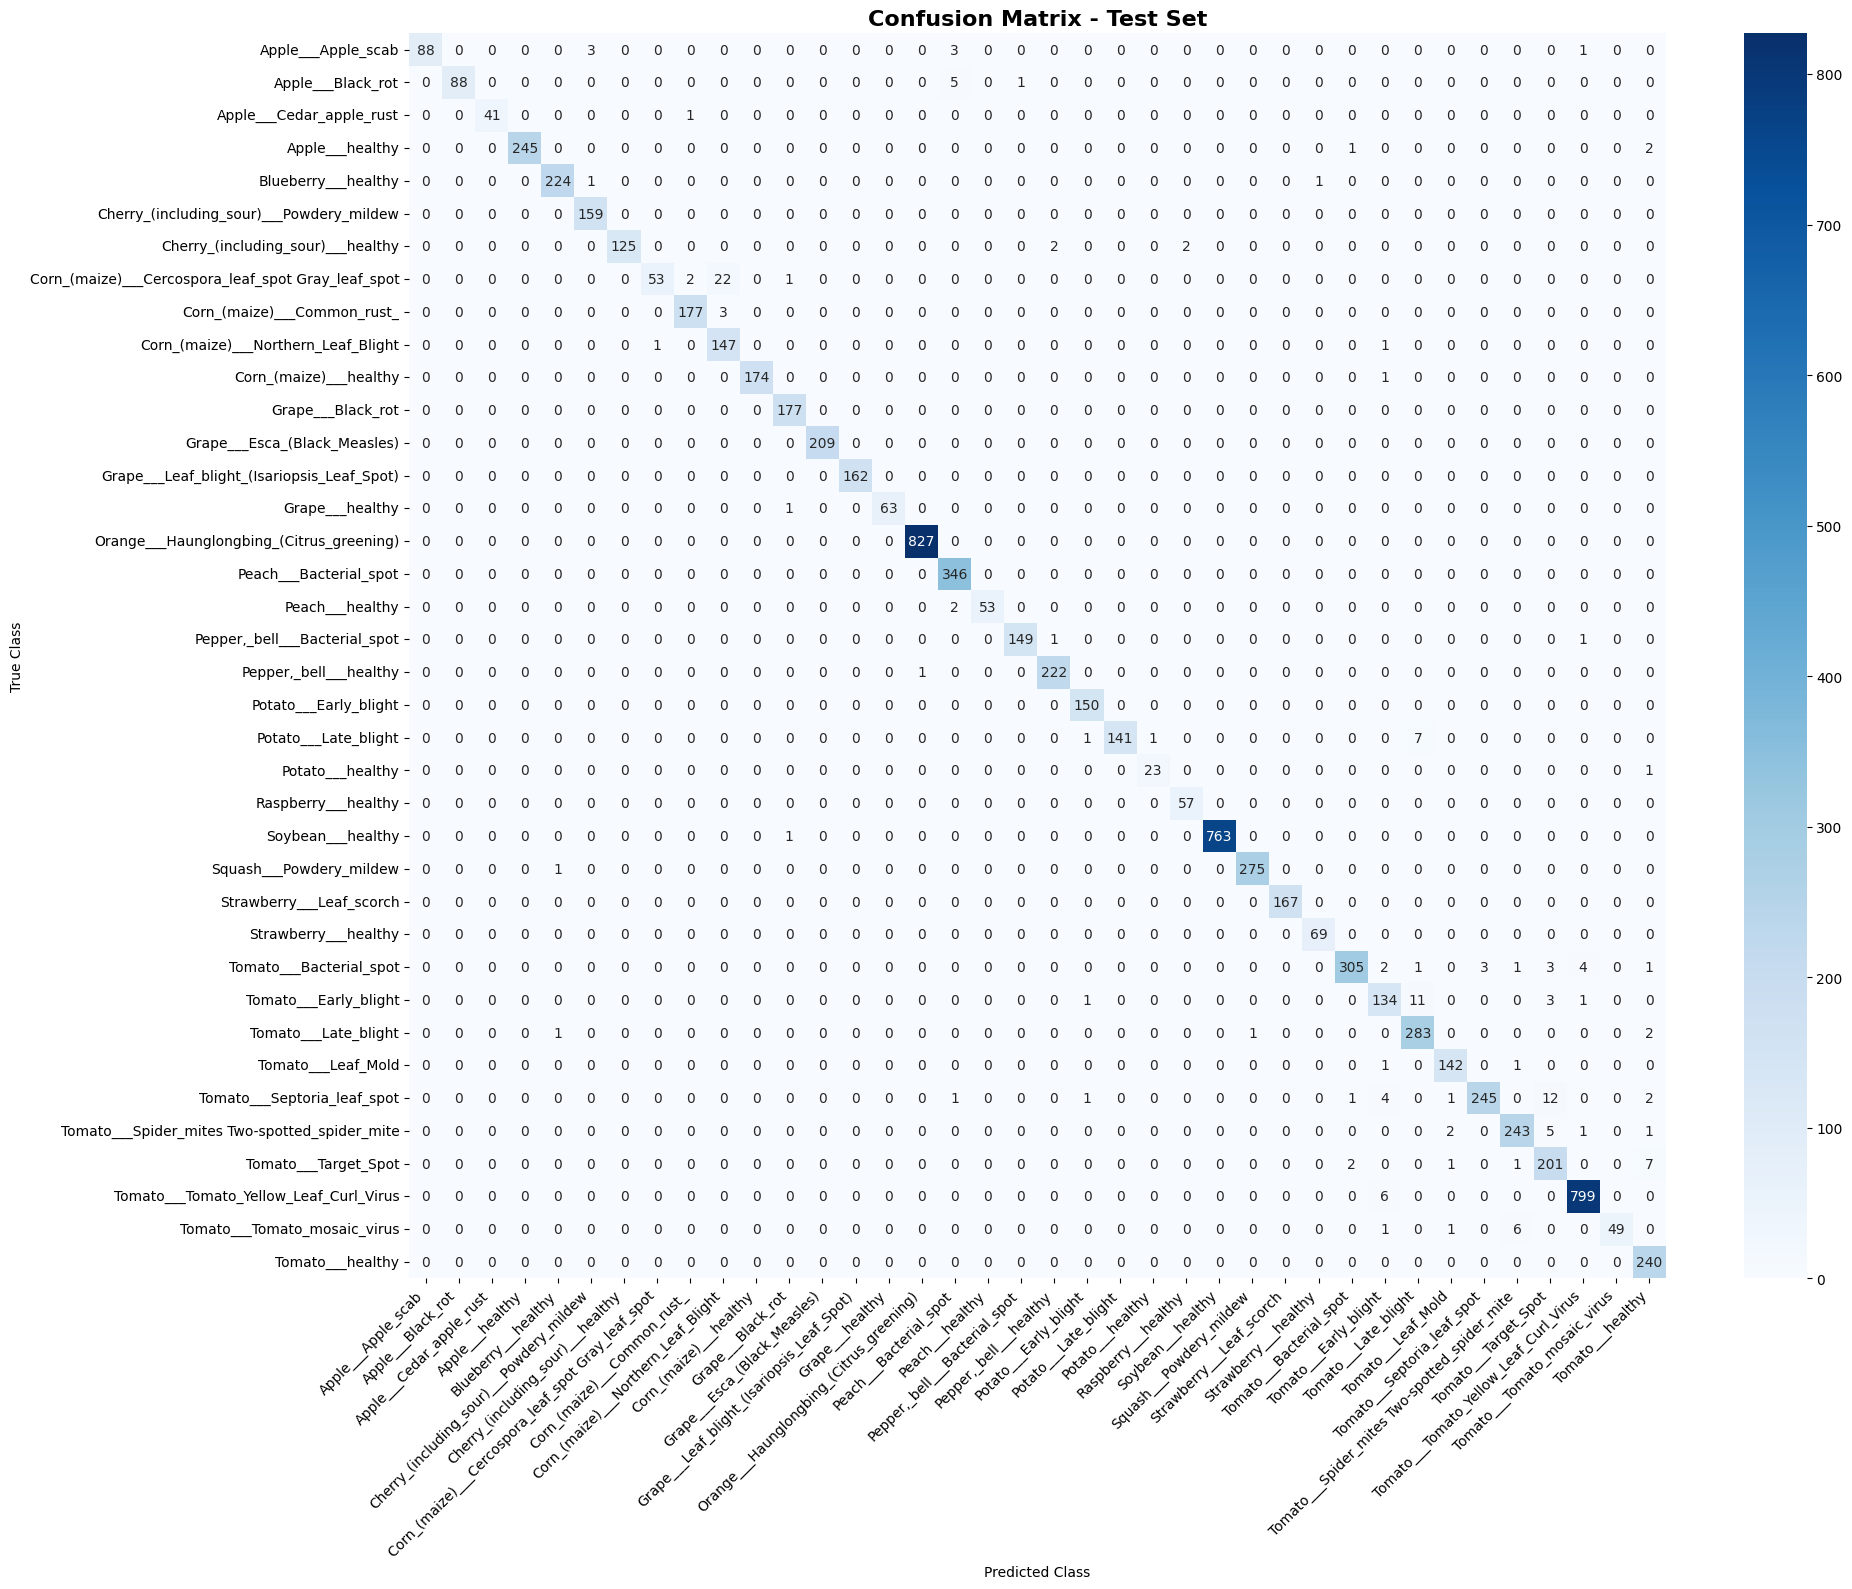


📊 Detailed Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.9263    0.9617        95
                                 Apple___Black_rot     1.0000    0.9362    0.9670        94
                          Apple___Cedar_apple_rust     1.0000    0.9762    0.9880        42
                                   Apple___healthy     1.0000    0.9879    0.9939       248
                               Blueberry___healthy     0.9912    0.9912    0.9912       226
          Cherry_(including_sour)___Powdery_mildew     0.9755    1.0000    0.9876       159
                 Cherry_(including_sour)___healthy     1.0000    0.9690    0.9843       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9815    0.6795    0.8030        78
                       Corn_(maize)___Common_rust_     0.9833    0.9833    0.9833       180
               Corn_(maize)___Northern_Leaf_

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print_section("CONFUSION MATRIX & CLASSIFICATION REPORT")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(all_labels, all_preds, 
                           target_names=train_dataset.classes,
                           digits=4))

In [ ]:
# CELL 18: Mislabeled Image Detection (Add after Cell 17)

print_section("MISLABELED IMAGE DETECTION")

from torch.nn import functional as F

def detect_mislabeled_candidates(model, dataloader, dataset, device, top_k=100):
    """
    Detect potentially mislabeled images by finding high-loss, 
    low-confidence predictions that are incorrect.
    """
    model.eval()
    suspicious_samples = []
    
    with torch.no_grad():
        sample_idx = 0
        for images, labels in tqdm(dataloader, desc="Scanning for mislabeled"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            
            # Get predictions and confidence
            max_probs, predictions = torch.max(probabilities, dim=1)
            
            # Calculate per-sample loss
            losses = F.cross_entropy(outputs, labels, reduction='none')
            
            # Find incorrect predictions
            incorrect_mask = predictions != labels
            
            for i in range(len(images)):
                if incorrect_mask[i]:
                    actual_idx = sample_idx + i
                    img_path, true_label = dataset.samples[actual_idx]
                    
                    suspicious_samples.append({
                        'index': actual_idx,
                        'path': img_path,
                        'filename': os.path.basename(img_path),
                        'true_class': dataset.classes[true_label],
                        'predicted_class': dataset.classes[predictions[i].item()],
                        'confidence': float(max_probs[i].item()),
                        'loss': float(losses[i].item()),
                        'true_label_prob': float(probabilities[i][true_label].item())
                    })
            
            sample_idx += len(images)
    
    # Sort by loss (highest first)
    suspicious_samples.sort(key=lambda x: x['loss'], reverse=True)
    
    return suspicious_samples[:top_k]


# Create non-augmented loader for training set
train_eval_dataset = datasets.ImageFolder(train_dir, transform=transform_val_test)
train_eval_loader = DataLoader(
    train_eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# Detect suspicious samples
print("🔍 Analyzing training set for potentially mislabeled images...")
suspicious = detect_mislabeled_candidates(
    model, train_eval_loader, train_eval_dataset, device, top_k=100
)

# Display results
print(f"\n🔍 Top {len(suspicious)} Potentially Mislabeled Images:")
print("-" * 100)
print(f"{'#':<4} {'True Class':<35} {'Predicted':<35} {'Loss':<8} {'Conf':<8}")
print("-" * 100)

for idx, sample in enumerate(suspicious[:20], 1):
    print(f"{idx:<4} {sample['true_class'][:33]:<35} {sample['predicted_class'][:33]:<35} "
          f"{sample['loss']:<8.3f} {sample['confidence']:<8.3f}")

if len(suspicious) > 20:
    print(f"... and {len(suspicious) - 20} more suspicious samples")

# Save report
mislabeled_report = {
    'total_suspicious': len(suspicious),
    'detection_method': 'high_loss_incorrect_predictions',
    'threshold_info': 'Top 100 samples sorted by loss (descending)',
    'samples': suspicious
}

mislabeled_log_path = os.path.join(working_base, 'mislabeled_candidates.json')
with open(mislabeled_log_path, 'w') as f:
    json.dump(mislabeled_report, f, indent=4)

print(f"\n📝 Mislabeled candidates saved to: {mislabeled_log_path}")

# Visualize top suspicious images
if len(suspicious) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Top 10 Potentially Mislabeled Images (Highest Loss)', 
                 fontsize=14, fontweight='bold')
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(suspicious):
            sample = suspicious[idx]
            try:
                img = Image.open(sample['path']).convert('RGB')
                ax.imshow(img)
                ax.set_title(f"Label: {sample['true_class'][:20]}\n"
                            f"Pred: {sample['predicted_class'][:20]}\n"
                            f"Loss: {sample['loss']:.2f}", fontsize=8)
            except:
                ax.text(0.5, 0.5, 'Image\nLoad\nError', ha='center', va='center')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(working_base, 'mislabeled_visualization.png'), dpi=150)
    plt.show()

print("\n✅ Mislabeled detection complete!")
print("⚠️  Review flagged images manually to confirm if truly mislabeled.")